In [1]:
import sys

sys.path.append('..')


In [2]:
import os
import logging

import numpy as np
from ase.io import read

import os
import numpy as np
from original import GP_for_MFF
from original import Kernels


from original import better_MFF_database
from original.better_MFF_database import carve_confs

import matplotlib.pyplot as plt

better_MFF_database.USE_ASAP = True
logging.basicConfig(level=logging.INFO)

# Parameters


In [26]:

r_cut = 4.5
n_data = 3000


nbodies = 2
sigma = 1.0
noise = 0.00001

ntr = 100
ntest = 50

directory = 'data/HNi/'
filename = directory + 'movie.xyz'


In [27]:

# # Open file and get number of atoms and steps
# traj = read(filename, index=slice(None), format='extxyz')

# elements, confs, forces, energies = carve_confs(traj, r_cut, n_data, forces_label='force')

# if not os.path.exists(directory):
#     os.makedirs(directory)

# np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
# np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
# np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

# lens = [len(conf) for conf in confs]

# logging.info('\n'.join((
#     'Number of atoms in a configuration:',
#     '   maximum: {}'.format(np.max(lens)),
#     '   minimum: {}'.format(np.min(lens)),
#     '   average: {:.4}'.format(np.mean(lens))
# )))


# GP

In [28]:
# Get configurations and forces from file
confs = np.load('{:s}/confs_cut={:.2f}.npy'.format(directory, r_cut))
forces = np.load('{:s}/forces_cut={:.2f}.npy'.format(directory, r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into testing and training dataset
tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Load, or train, the GP
if nbodies == 3:
    ker = Kernels.ThreeBody(theta=[sigma, r_cut / 10.0, r_cut])
elif nbodies == 2:
    ker = Kernels.TwoBody(theta=[sigma, r_cut / 10.0, r_cut])
else:
    NotImplementedError('Kernel order not understood, use 2 for two-body and 3 for three-body')

gp = GP_for_MFF.GaussianProcess(kernel=ker, noise=noise, optimizer=None)
gp_name = 'gp_ker={}_ntr={}_sig={:.2f}_cut={:.2f}'.format(nbodies, ntr, sigma, r_cut)

gp.fit(tr_confs, tr_forces)
gp.save(directory + gp_name)




Started compilation of theano two body kernels
Ended compilation of theano two body kernels
Saved Gaussian process with name: data/HNi/gp_ker=2_ntr=100_sig=1.00_cut=4.50


# Test the GP performance

In [17]:
print('Testing the GP module')
gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = gp.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

print('MAEF on forces: {:.4f} +- {:.4f}'.format(
    np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1))),
    np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))))

Testing the GP module
MAEF on forces: 0.0593 +- 0.0341


# Learning curve


N train: [20, 60, 100, 140, 180, 220, 260, 300], N test: 50
Training GP
Testing GP
RMSE: 0.05504
MAEC: 0.03502
MAEF: 0.0746 +- 0.0593
Relative MAEF on forces: 0.0799 +- 0.0635
Training GP
Testing GP
RMSE: 0.0497
MAEC: 0.03083
MAEF: 0.0650 +- 0.0565
Relative MAEF on forces: 0.0696 +- 0.0605
Training GP
Testing GP
RMSE: 0.04705
MAEC: 0.0297
MAEF: 0.0619 +- 0.0529
Relative MAEF on forces: 0.0663 +- 0.0567
Training GP
Testing GP
RMSE: 0.04441
MAEC: 0.02864
MAEF: 0.0596 +- 0.0486
Relative MAEF on forces: 0.0638 +- 0.0521
Training GP
Testing GP
RMSE: 0.03928
MAEC: 0.02737
MAEF: 0.0563 +- 0.0381
Relative MAEF on forces: 0.0603 +- 0.0408
Training GP
Testing GP
RMSE: 0.03752
MAEC: 0.02864
MAEF: 0.0575 +- 0.0304
Relative MAEF on forces: 0.0615 +- 0.0325
Training GP
Testing GP
RMSE: 0.03931
MAEC: 0.03024
MAEF: 0.0600 +- 0.0323
Relative MAEF on forces: 0.0642 +- 0.0345
Training GP
Testing GP
RMSE: 0.03859
MAEC: 0.02975
MAEF: 0.0591 +- 0.0313
Relative MAEF on forces: 0.0632 +- 0.0335


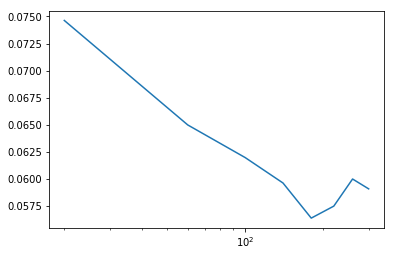

In [24]:
ntrs = [20, 60, 100, 140, 180, 220, 260, 300]
ntest = 50
print('N train: {}, N test: {}'.format(ntrs, ntest))
errors = []
np.random.seed(42)

for ntr in ntrs:

    # Get configurations and forces from file
    confs = np.load('{:s}/confs_cut={:.2f}.npy'.format(directory, r_cut))
    forces = np.load('{:s}/forces_cut={:.2f}.npy'.format(directory, r_cut))
    # numconfs = len(forces)
    # ind = np.arange(numconfs)
    # ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

    # # Separate into testing and training dataset
    # tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
    # tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

    # Use fixed training and testing dataset
    tr_confs, tr_forces = confs[:ntr], forces[:ntr]
    tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]
    
    print('Training GP')

    gp.fit(tr_confs, tr_forces)

    # Test the GP performance
    print('Testing GP')

    gp_forces = np.zeros((ntest, 3))
    gp_error = np.zeros((ntest, 3))

    for i in np.arange(ntest):
        gp_forces[i, :] = gp.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

    MAEC = np.mean(abs(gp_error))
    MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
    RMSE = np.sqrt(np.mean((gp_error) ** 2))

    MF = np.mean(np.linalg.norm(tst_forces, axis=1))

    print('RMSE: {:.4}'.format(RMSE))
    print('MAEC: {:.4}'.format(MAEC))
    print('MAEF: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
    print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

    errors.append(MAEF)

plt.plot(ntrs, errors)
plt.xscale('log')
plt.show()


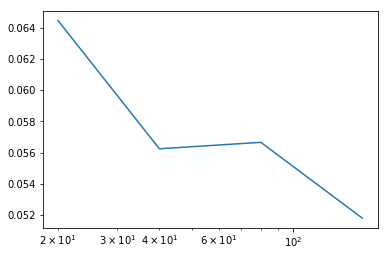

In [21]:
plt.plot(ntrs, errors)
plt.xscale('log')
plt.show()
